In [1]:
import rebound
import reboundx
import numpy as np
import scipy
from scipy import signal
from tqdm import tqdm_notebook
import pandas as pd

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

# Definitions

In [2]:
radeg = np.pi/180

########################
# Define functions for adding a number of generated Trojan asteroids at ~L4/L5
########################

def add_L4(sim, number):
    a_rand = np.random.normal(38,2,size=number)
    a_rand = a_rand/100 + 5
    e_rand = np.random.normal(9,2,size=number)
    e_rand = e_rand/100
    w_rand = np.random.normal(60,4,size=number)*radeg
    half = int(number/2)
    i_rand1 = np.random.normal(9,4,size=half+1)*radeg
    i_rand2 = np.random.normal(-9,4,size=half)*radeg
    i_rand = np.concatenate((i_rand1,i_rand2))
        
    for i in range(number):
        sem = a_rand[i]
        ecc = e_rand[i]
        icl = i_rand[i]
        Ome = w_rand[i]
        has = 'L4 {0}'.format(i)
        sim.add(m=0, primary=sim.particles['Sun'], a=sem, e=ecc, inc=icl, Omega=Ome, hash=has)
    return

def add_L5(sim, number):
    a_rand = np.random.normal(38,2,size=number)
    a_rand = a_rand/100 + 5
    e_rand = np.random.normal(9,2,size=number)
    e_rand = e_rand/100
    w_rand = -np.random.normal(60,4,size=number)*radeg
    half = int(number/2)
    i_rand1 = np.random.normal(9,4,size=half+1)*radeg
    i_rand2 = np.random.normal(-9,4,size=half)*radeg
    i_rand = np.concatenate((i_rand1,i_rand2))
    
    for i in range(number):
        sem = a_rand[i]
        ecc = e_rand[i]
        icl = i_rand[i]
        Ome = w_rand[i]
        has = 'L5 {0}'.format(i)
        sim.add(m=0, primary=sim.particles['Sun'], a=sem, e=ecc, inc=icl, Omega=Ome, hash=has)
    return

In [3]:
def masses(x):
    # for input array of time values, approximate M_star (in M_sol) at those times in its life
    y = np.zeros_like(x)
    for i, time in enumerate(x):
        if (time <= 1.132e10):
            y[i] = 1
        elif (1.132e10 < time <= 1.1336e10):
            y[i] = 0.05 * (708.5 - time/(1.6e7))**(1/3) + .95
        elif (1.1336e10 < time <= 1.1463e10):
            y[i] =  -8**((time - 1.1463e10)/574511)/2.4 + .95
        elif (1.1463e10 < time):
            y[i] = 0.532
    return y

def lums_array(x):
    # for input array of time values, approximate log(L_star) (in log(L_sol)) at those times
    y = np.zeros_like(x)
    for i, time in enumerate(x):
        if (time <= 1.113e10):
            y[i] = 1.05
        elif (1.113e10 < time <= 1.1225e10):
            y[i] = 1.45 + ((1.45 - 1.1)/(1.1225e10 - 1.1135e10))*(time - 1.1225e10)
        elif (1.1225e10 < time <= 1.125e10):
            y[i] = 1.45
        elif (1.125 < time <= 1.1336e10):
            y[i] = 1.35 + .1*1.002**((time - 1.125e10)/58000)
        elif (1.1336e10 < time <= 1.142e10):
            y[i] = 1.673
        elif (1.142e10 < time <= 1.14397e10):
            y[i] = 3.198e-9*time - 34.85
        elif (1.14397e10 < time <= 1.14479e10):
            y[i] = 1.736 + 0.032*1.5**((time - 1.14455e10)/360000)
        elif (1.14479e10 < time <= 1.1462e10):
            y[i] = 2.15 + 0.00021*1.5**((time - 1.1444e10)/870000)
        elif (1.1462e10 < time <= 1.14632e10):
            y[i] = 3.5 + (.43/0.0001e10)*(time - 1.1463e10)
        elif (1.14632e10 < time <= 1.14636e10):
            y[i] = 2.3*((time - 1.1463e10)/45000)**(-0.3)
        elif (1.14636e10 < time <= 1.14654715e10):
            y[i] = .2 + ((.2 - 1.05)/(1.14654715e10 - 1.14636e10))*(time - 1.14654715e10)
        elif (1.14654715e10 < time):
            y[i] = .2
    return y        
        
def inst_lum(x):
    # for a single time input, output log(L_star) (in log(L_sol)) at that time
    time = x
    if (time <= 1.113e10):
        y = 1.05
    elif (1.113e10 < time <= 1.1225e10):
        y = 1.45 + ((1.45 - 1.1)/(1.1225e10 - 1.1135e10))*(time - 1.1225e10)
    elif (1.1225e10 < time <= 1.125e10):
        y = 1.45
    elif (1.125 < time <= 1.1336e10):
        y = 1.35 + .1*1.002**((time - 1.125e10)/58000)
    elif (1.1336e10 < time <= 1.142e10):
        y = 1.673
    elif (1.142e10 < time <= 1.14397e10):
        y = 3.198e-9*time - 34.85
    elif (1.14397e10 < time <= 1.14479e10):
        y = 1.736 + 0.032*1.5**((time - 1.14455e10)/360000)
    elif (1.14479e10 < time <= 1.1462e10):
        y = 2.15 + 0.00021*1.5**((time - 1.1444e10)/870000)
    elif (1.1462e10 < time <= 1.14632e10):
        y = 3.5 + (.43/0.0001e10)*(time - 1.1463e10)
    elif (1.14632e10 < time <= 1.14636e10):
        y = 2.3*((time - 1.1463e10)/45000)**(-0.3)
    elif (1.14636e10 < time <= 1.14654715e10):
        y = .2 + ((.2 - 1.05)/(1.14654715e10 - 1.14636e10))*(time - 1.14654715e10)
    elif (1.14654715e10 < time):
        y = .2
    return y

Below, we define our all-important custom force, derived from Veras et al. 2019 eq. 23, using their Model A to encapsulate edge case Yarkovsky physics

In [4]:
def yark(simp, rebx_force, particles, N):
    sim = simp.contents
    part = sim.particles
    
    current_time = sim.t + T0
    L_sol = np.exp(inst_lum(current_time))*0.000235 # solar luminosity in au^2 M_sol/yr^3
    
    sim.move_to_hel()
    for troj in range(num_tr):
    
        i = troj + 1
        
        x = part[i].x  ; y = part[i].y  ; z = part[i].z
        R = troj_radii[i-1]
        m_ast = troj_masses[i-1]
    
        c = 63197.8 # speed of light in au/yr
        r = np.sqrt(x**2 + y**2 + z**2)
        A = (R**2 * L_sol)/(4*m_ast*c)
    
        part[i].ax += (A/r**3) * x
        part[i].ay += (A/r**3) * (0.25*x + y)
        part[i].az += (A/r**3) * z
    return

The definitions below allow for us to easily plot the locations of asteroids on separatrices at various stages of integration

In [5]:
def roch2(x,y,M1,M2,a):
    q = M2/M1
    x /= a
    y /= a
    s1 = np.sqrt(x**2 + y**2)
    s2 = np.sqrt((x-1)**2 + y**2)
    
    term1 = 2/(s1*(1+q))
    term2 = 2*q/(s2*(1+q))
    term3 = (x - q/(1+q))**2
    term4 = y**2
    return term1 + term2 + term3 + term4

def cart_to_pol(x,y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    return r, phi

def pol_to_cart(r,phi):
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    return x, y

def L45(msun,mjup):
    u2 = mjup/(msun+mjup)
    
    x_L4 = 0.5 - u2
    x_L5 = x_L4
    
    y_L4 = np.sqrt(3)/2
    y_L5 = -y_L4
    
    return np.array([x_L4,x_L5]), np.array([y_L4,y_L5])

def separatrix(msun, mjup, asun, ajup):
    # masses are in units of solar mass
    # distances are in units of jupiter's distance from the origin
    
    delta = 0.001
    x1 = np.arange(-1.2, 1.2, delta)
    y1 = np.arange(-1.2, 1.2, delta)
    X1, Y1 = np.meshgrid(x1, y1)

    z1 = roch2(X1,Y1,msun,mjup,ajup)

    u2 = mjup/(msun+mjup)
    u1 = 1 - u2
    alph = (u2/3*u1)**(1/3)
    
    l1 = ajup -(alph - (1/3)*alph**2 - (1/9)*alph**3 - (23/81)*alph**4)
    l2 = ajup + alph + (1/3)*alph**2 - (1/9)*alph**3 - (31/81)*alph**4
    l3 = asun + 1 - (7/12)*(u2/u1) + (7/12)*(u2/u1)**2 - (13223/20736)*(u2/u1)**3

    P1 = roch2(l1,0,msun,mjup,1)
    P2 = roch2(l2,0,msun,mjup,1)
    P3 = roch2(-l3,0,msun,mjup,1)

    Jconsts = np.array([P3, P2, P1])
    
    return X1, Y1, z1, Jconsts

def sep_lag_plot(time, tit):
    R_jup = np.sqrt(x_jup[time]**2 + y_jup[time]**2)
    r_sun = np.sqrt(x_sol[time]**2 + y_sol[time]**2)
    separ = R_jup + r_sun

    r_jup = R_jup/separ
    r_sun /= separ

    if time == 0:
        msol = M0
    else:
        msol = mtimes[time]
        
    X1, Y1, Z1, lines1 = separatrix(msol, 9.543e-4, r_sun, r_jup)

    jup_x = x_jup[time]/separ
    jup_y = y_jup[time]/separ

    sol_x = x_sol[time]/separ
    sol_y = y_sol[time]/separ

    ast_x = x_vals.T[time,:]/separ
    ast_y = y_vals.T[time,:]/separ

    L45_x, L45_y = L45(msol,9.543e-4)

    ast_r, ast_phi = cart_to_pol(ast_x,ast_y)
    sol_r, sol_phi = cart_to_pol(sol_x,sol_y)
    jup_r, jup_phi = cart_to_pol(jup_x,jup_y)

    ast_phi -= jup_phi
    sol_phi -= jup_phi
    jup_phi -= jup_phi

    ast_x, ast_y = pol_to_cart(ast_r,ast_phi)
    sol_x, sol_y = pol_to_cart(sol_r,sol_phi)
    jup_x, jup_y = pol_to_cart(jup_r,jup_phi)

    fig, ax = plt.subplots(figsize=(10,10))

    ax.contour(X1,Y1,Z1,lines1, colors='k', alpha=.2)
    ax.scatter(L45_x,L45_y, c='k', lw=3,s=150, marker="x",zorder=10)
    ax.scatter(ast_x[:num_L4],ast_y[:num_L4],c="r",alpha=0.3)
    ax.scatter(ast_x[num_L4:],ast_y[num_L4:],c="b",alpha=0.3)
    ax.scatter(sol_x,sol_y, c="gold",s=300,zorder=10)
    ax.scatter(jup_x,jup_y, c="peru",s=200,zorder=10)

    ax.vlines(0,-1.2,1.2,colors='k',alpha=0.2)
    ax.hlines(0,-1.2,1.2,colors='k',alpha=0.2)
    ax.set_aspect("equal")
    ax.set_ylim(-1.2,1.2)
    ax.set_xlim(-1.2,1.2)
    ax.set_xlabel(r"au / $a_{jup}$", fontsize=16)
    ax.set_ylabel(r"au / $a_{jup}$", fontsize=16)
    ax.set_title(tit, fontsize=16)
    fig.show()
    #fig.savefig("troj3-ast-on-separatrix-start.png", dpi=300)
    return

# Setup

First, we set an array of masses and luminosities over the period of interest.

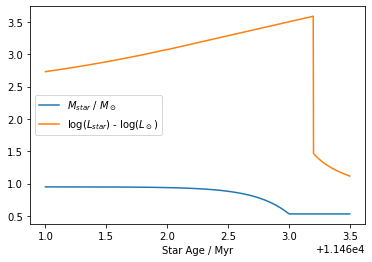

In [95]:
N_times = 1000
T0 = 1.14610e10
t_tot = 2500000

ts = np.linspace(0, t_tot, N_times)
mtimes = masses(ts + T0)
lumins = lums_array(ts + T0)

plt.plot((ts + T0)/1e6, mtimes)
plt.plot((ts + T0)/1e6, lumins)
plt.legend([r"$M_{star}$ / $M_\odot$", r"log($L_{star}$) - log($L_\odot$)"])
plt.xlabel("Star Age / Myr")
plt.show()

Next we create a REBOUND simulation and add a Sun-like star, a Jupiter-like planet, and random Trojan asteroids.

Star initial mass: 0.9497008200052872 M_sol
Star initial age:  11461000000.0 yrs


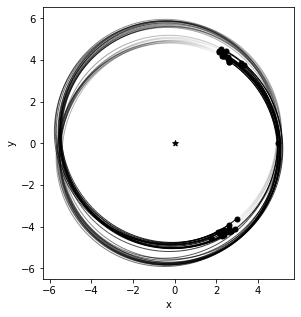

In [96]:
sim = rebound.Simulation()

M0 = mtimes[0]
print("Star initial mass:", M0, "M_sol")
print("Star initial age: ", T0, "yrs")

radeg = np.pi/180
om_jup = 14.753*radeg

num_L4 = 15
num_L5 = 15
num_tr = num_L4 + num_L5

#############
# Add sun, trojans, Jupiter
#############

sim.add(m=M0,x=0, y=0, z=0, vx=0, vy=0, vz=0, hash='Sun')
add_L4(sim, num_L4)
add_L5(sim, num_L5)
sim.add(m=9.543e-4, a=5.2, e=.04839, inc=.022689, Omega=0, omega=0, hash='jupiter')

#############
#set simulation parameters
#############

sim.integrator = 'whfast'
sim.dt = 0.5
sim.move_to_com()

ps = sim.particles
fig, ax = rebound.OrbitPlot(sim)

In [97]:
Nout = 100000
times = np.linspace(0,t_tot,Nout)
mstar = np.zeros(Nout)

In [98]:
rebx = reboundx.Extras(sim)

starmass = reboundx.Interpolator(rebx, ts, mtimes, 'spline')

yrkv = rebx.create_force("yarkovsky")

yrkv.force_type = "pos"
yrkv.update_accelerations = yark
rebx.add_force(yrkv)

The cell below assigns masses to each asteroid. The REBOUND simulation treats them as massless for gravitational effects in order to speed up integration, but this approximation is not valid when studying the Yarkovsky effect. 

In [99]:
rad_ast = 10                                        # radius in km
troj_radii = np.full(num_tr, rad_ast/1.496e+8)      # gives each asteroid a radius in AU

mass_typic = 3*(4/3)*np.pi*(rad_ast*100000)**3      # gives typical mass @ this radius, w/ density = 3 g cm^-3
troj_masses = np.random.normal(mass_typic, .3*mass_typic, num_tr)        
                                                    # gives array of values around that mass
troj_masses /= 1.9891e33                            # divides each mass by M_sol to get masses in M_sol

print("Typical asteroid mass:", mass_typic, "g")
print("Average asteroid mass:", np.mean(troj_masses), "M_sol")

Typical asteroid mass: 1.2566370614359173e+19 g
Average asteroid mass: 6.4301212207085496e-15 M_sol


Here, we initialize arrays for tracking the evolution of orbital parameters for each body over the course of the integration.

In [100]:
mass = np.zeros(Nout)

x_sol = np.zeros(Nout); y_sol = np.zeros(Nout); z_sol = np.zeros(Nout)
x_sol[0] = ps['Sun'].x
y_sol[0] = ps['Sun'].y
z_sol[0] = ps['Sun'].z

x_jup = np.zeros(Nout); y_jup = np.zeros(Nout); z_jup = np.zeros(Nout)
x_jup[0] = ps['jupiter'].x
y_jup[0] = ps['jupiter'].y
z_jup[0] = ps['jupiter'].z

a_jup = np.zeros(Nout)
e_jup = np.zeros(Nout) 
i_jup = np.zeros(Nout)
pmjup = np.zeros(Nout)
lmjup = np.zeros(Nout)

a_jup[0] = ps['jupiter'].a
e_jup[0] = ps['jupiter'].e
i_jup[0] = ps['jupiter'].inc
pmjup[0] = ps['jupiter'].pomega
lmjup[0] = ps['jupiter'].l

a_vals = np.zeros((num_tr, Nout))
e_vals = np.zeros((num_tr, Nout))
i_vals = np.zeros((num_tr, Nout))
pmvals = np.zeros((num_tr, Nout))
lmvals = np.zeros((num_tr, Nout))

x_vals = np.zeros((num_tr, Nout))
y_vals = np.zeros((num_tr, Nout))

for moon in range(num_L4):
    a_vals[moon,0] = ps['L4 {0}'.format(moon)].a
    e_vals[moon,0] = ps['L4 {0}'.format(moon)].e
    i_vals[moon,0] = ps['L4 {0}'.format(moon)].inc
    lmvals[moon,0] = ps['L4 {0}'.format(moon)].l
    pmvals[moon,0] = ps['L4 {0}'.format(moon)].pomega
    x_vals[moon,0] = ps['L4 {0}'.format(moon)].x
    y_vals[moon,0] = ps['L4 {0}'.format(moon)].y
    
for moon in range(num_L5):
    a_vals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].a
    e_vals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].e
    i_vals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].inc
    lmvals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].l
    pmvals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].pomega
    x_vals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].x
    y_vals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].y

### Initial locations on separatrix

Here we plot the initial locations of each asteroid on a separatrix depicting the gravitational potential of the star-planet system.

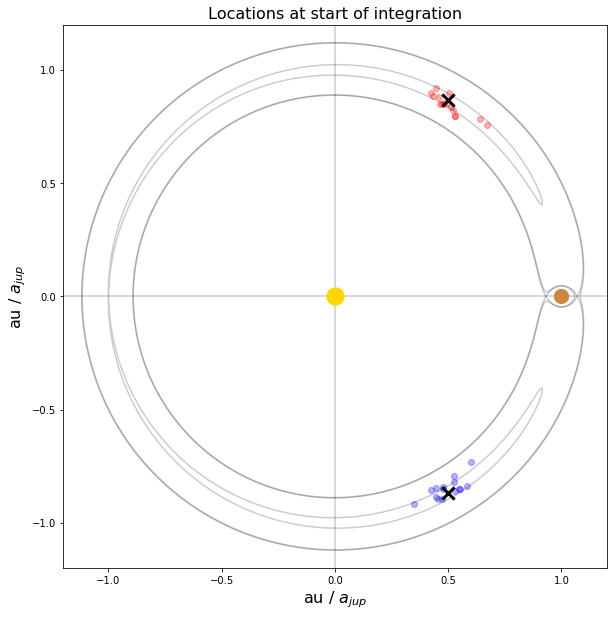

In [101]:
sep_lag_plot(0,"Locations at start of integration")

# Integration

In [102]:
%%time

for i, time in enumerate(times):
    sim.integrate(time)
    
    ps[0].m = starmass.interpolate(rebx, t=sim.t)
    sim.move_to_com()
    
    mass[i] = ps['Sun'].m
    x_sol[i] = ps['Sun'].x
    y_sol[i] = ps['Sun'].y
    z_sol[i] = ps['Sun'].z
        
    x_jup[i] = ps['jupiter'].x
    y_jup[i] = ps['jupiter'].y 
    z_jup[i] = ps['jupiter'].z
    a_jup[i] = ps['jupiter'].a
    e_jup[i] = ps['jupiter'].e
    i_jup[i] = ps['jupiter'].inc
    pmjup[i] = ps['jupiter'].pomega
    lmjup[i] = ps['jupiter'].l

    for moon in range(num_L4):
        a_vals[moon,i] = ps['L4 {0}'.format(moon)].a
        e_vals[moon,i] = ps['L4 {0}'.format(moon)].e
        i_vals[moon,i] = ps['L4 {0}'.format(moon)].inc
        lmvals[moon,i] = ps['L4 {0}'.format(moon)].l
        pmvals[moon,i] = ps['L4 {0}'.format(moon)].pomega
        x_vals[moon,i] = ps['L4 {0}'.format(moon)].x
        y_vals[moon,i] = ps['L4 {0}'.format(moon)].y

    for moon in range(num_L5):
        a_vals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].a
        e_vals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].e
        i_vals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].inc
        lmvals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].l
        pmvals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].pomega
        x_vals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].x
        y_vals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].y

CPU times: user 51min, sys: 5.77 s, total: 51min 6s
Wall time: 51min 12s


'vel'-type Runtime ~ 2.35n + 8 minutes
'pos'-type Runtime ~ 1.66n + 1 minutes


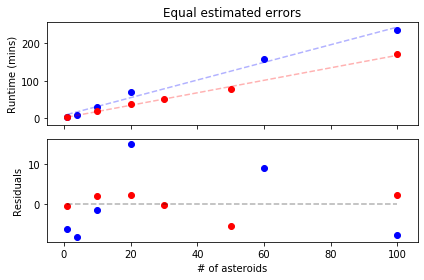

In [2]:
n = np.array([1,4,10,20,60,100])
npos = np.array([1,10,20,30,50,100])
numbers_of_parts = np.logspace(0,2,100)
time_taken_to_int = np.array([4,9,30,70,158,235])
time_taken_to_int_pos = np.array([2.5,20,37,51,79,170])
#errorbars = 1
errorbars = np.ones_like(n)
errorbar2 = np.ones_like(npos)

X = np.vander(n,N=2,increasing=True)
C = np.diag(errorbars**2)
Ci = np.linalg.inv(C)

X2 = np.vander(npos,N=2,increasing=True)
C2 = np.diag(errorbar2**2)
Ci2 = np.linalg.inv(C2)

pars = np.linalg.inv(X.T @ Ci @ X) @ (X.T @ Ci @ time_taken_to_int)
pars2 = np.linalg.inv(X2.T @ Ci2 @ X2) @ (X2.T @ Ci2 @ time_taken_to_int_pos)

def lin(ba, x):
    b,a = ba
    y = a*x + b
    return y

x_ = np.logspace(0,2,100)
y_1 = lin(pars,x_)
y_2 = lin(pars2,x_)

fig, ax = plt.subplots(2,sharex=True)
ax[0].scatter(n,time_taken_to_int,c='b')
ax[0].scatter(npos,time_taken_to_int_pos,c='r')
ax[0].plot(x_, y_1,c='b',ls='--',alpha=0.3)
ax[0].plot(x_, y_2,c='r',ls='--',alpha=0.3)
ax[0].set_ylabel("Runtime (mins)")
ax[1].set_ylabel("Residuals")
ax[1].set_xlabel("# of asteroids")
#ax[0].set_yscale('log')
#ax[0].set_xscale('log')
ax[1].plot(numbers_of_parts, np.zeros_like(numbers_of_parts),'k',ls='--',alpha=0.3)
ax[1].scatter(n,time_taken_to_int-lin(pars,n),c='b')
ax[1].scatter(npos,time_taken_to_int_pos-lin(pars2,npos),c='r')
ax[0].set_title("Equal estimated errors")
#ax[0].set_title(r"Errors estimated ~ $\frac{1}{\log{(n)}}$")
fig.tight_layout()
fig.show()

print("'vel'-type Runtime ~ %1.2fn + %1.f minutes" %(pars[1],pars[0]))
print("'pos'-type Runtime ~ %1.2fn + %1.f minutes" %(pars2[1],pars2[0]))

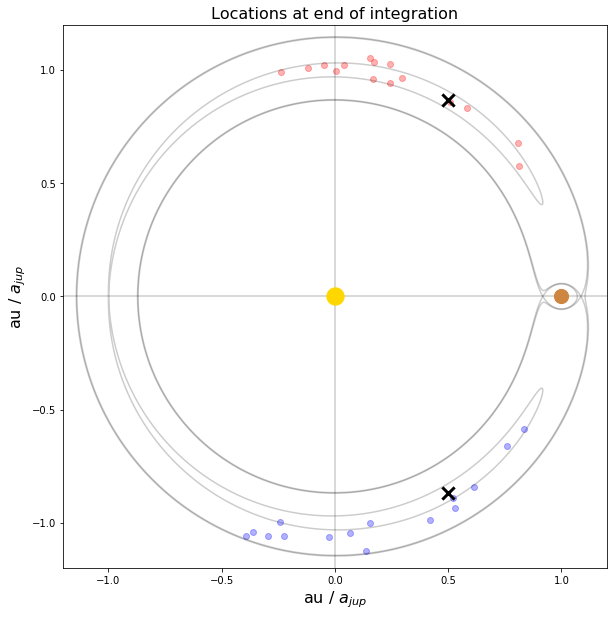

In [104]:
sep_lag_plot(999,"Locations at end of integration")

# Analysis

In [81]:
i_vals /= radeg

### Time series of orbital params

The evolution of various orbital parameters for the Jupiter-like planet, along with each asteroid.

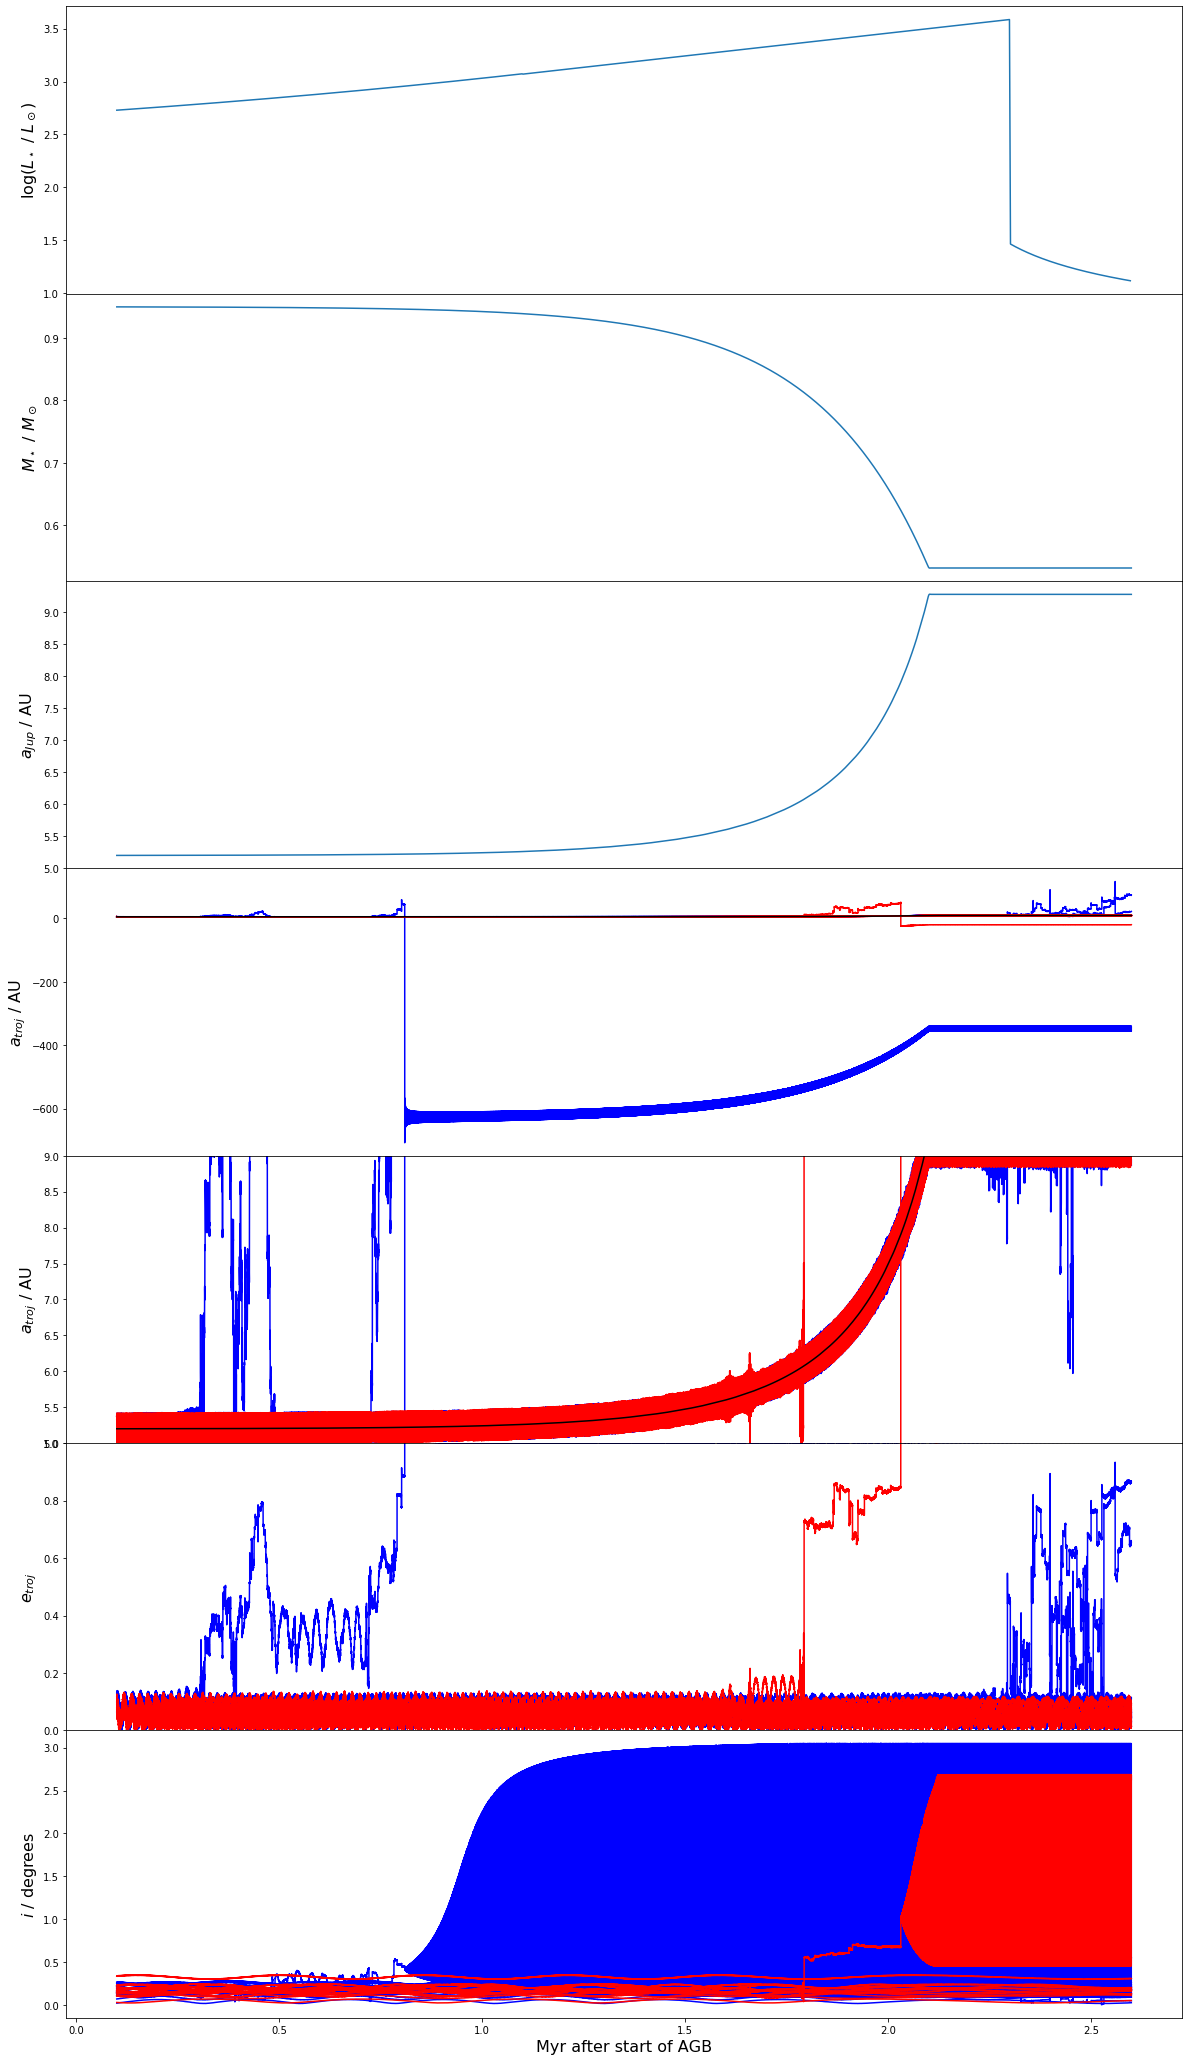

In [106]:
fig, ax = plt.subplots(7,1,figsize=(20,37), sharex=True)
plt.subplots_adjust(hspace=0)

end = 99999

ax[0].plot(ts[:999]/1e6+.1,lumins[:999])
ax[0].set_ylabel(r"log($L_\star$ / $L_\odot$)", fontsize=16)
ax[1].plot(times[:end]/1e6+.1,mass[:end])
ax[1].set_ylabel(r"$M_\star$ / $M_\odot$", fontsize=16)
ax[2].plot(times[:end]/1e6+.1,a_jup[:end])
ax[2].set_ylabel(r"$a_{Jup}$ / AU", fontsize=16)
ax[3].plot(times[:end]/1e6+.1, a_vals.T[:end, num_L4:], 'b')
ax[3].plot(times[:end]/1e6+.1, a_vals.T[:end, :num_L4], 'r')
ax[3].plot(times[:end]/1e6+.1, a_jup[:end], "k")
ax[3].set_ylabel(r"$a_{troj}$ / AU", fontsize=16)
ax[4].plot(times[:end]/1e6+.1, a_vals.T[:end, num_L4:], 'b')
ax[4].plot(times[:end]/1e6+.1, a_vals.T[:end, :num_L4], 'r')
ax[4].plot(times[:end]/1e6+.1, a_jup[:end], "k")
ax[4].set_ylim(5,9)
ax[4].set_ylabel(r"$a_{troj}$ / AU", fontsize=16)
ax[5].plot(times[:end]/1e6+.1, e_vals.T[:end, num_L4:], 'b')
ax[5].plot(times[:end]/1e6+.1, e_vals.T[:end, :num_L4], 'r')
ax[5].set_ylim(0,1)
ax[5].set_ylabel(r"$e_{troj}$", fontsize=16)
ax[6].plot(times[:end]/1e6+.1, i_vals.T[:end, num_L4:], 'b')
ax[6].plot(times[:end]/1e6+.1, i_vals.T[:end, :num_L4], 'r')
ax[6].set_ylabel(r"$i$ / degrees", fontsize=16)
ax[6].set_xlabel("Myr after start of AGB", fontsize=16)
#ax[6].set_ylim(-180,180)

fig.show()
#fig.savefig("troj3-all-elements.png", dpi=300)

In [123]:
a_diffs = np.zeros_like(a_vals)
for step in range(100000):
    a_diffs[:,step] = a_vals[:,step] - a_jup[step]

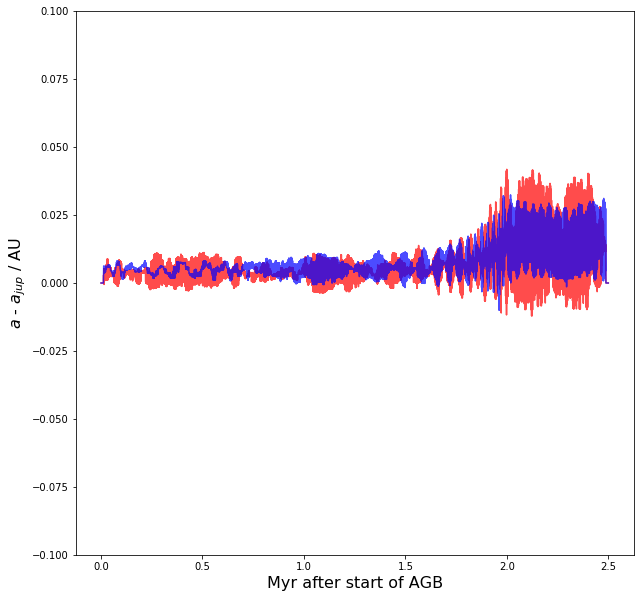

In [138]:
end = 99999
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(times[:end]/1e6,signal.medfilt(a_diffs.T[:end,10],kernel_size=1001),'r',alpha=0.7)
ax.plot(times[:end]/1e6,signal.medfilt(a_diffs.T[:end,20],kernel_size=1001),'b',alpha=0.7)
ax.set_ylim(-0.1,0.1)
ax.set_ylabel(r"$a$ - $a_{jup}$ / AU", fontsize=16)
ax.set_xlabel("Myr after start of AGB", fontsize=16)
fig.show()
#fig.savefig("troj3-i-changes.png", dpi=300)

### Orbits around Lagrange Points

Here we plot averaged orbits of some asteroids around their Lagrange points. Under that, we find the evolution of the 40-orbit-averaged distance from each asteroid to its Lagrange point.

NameError: name 'L45_x' is not defined

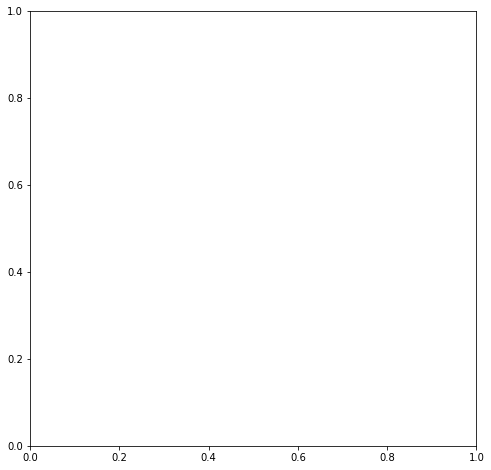

In [84]:
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(signal.medfilt(L45_x[0][:5000] - x_vals[2,:5000],499)[500:4500],signal.medfilt(L45_y[0][:5000] - y_vals[2,:5000],499)[500:4500])
ax.plot(signal.medfilt(L45_x[0][:5000] - x_vals[3,:5000],499)[500:4500],signal.medfilt(L45_y[0][:5000] - y_vals[3,:5000],499)[500:4500])
ax.plot(signal.medfilt(L45_x[0][:5000] - x_vals[4,:5000],499)[500:4500],signal.medfilt(L45_y[0][:5000] - y_vals[4,:5000],499)[500:4500])
ax.plot(signal.medfilt(L45_x[0][:5000] - x_vals[5,:5000],499)[500:4500],signal.medfilt(L45_y[0][:5000] - y_vals[5,:5000],499)[500:4500])
ax.scatter(0,0,marker="x",lw=3, s=200,c="k")
ax.axvline(0,c="k")
ax.axhline(0,c="k")
ax.set_aspect("equal")

In [50]:
%%time

n = 50
y = 85000
diffx = np.zeros((n,y))
diffy = np.zeros((n,y))

for i in range(n):
    diffx[i,:] = signal.medfilt(L45_x[0][:y] - x_vals[i,:y],499)
    diffy[i,:] = signal.medfilt(L45_y[0][:y] - y_vals[i,:y],499)

print("Wooooooooooah we're halfway there")

diffx5 = np.zeros((n,y))
diffy5 = np.zeros((n,y))
for i in range(n):
    diffx5[i,:] = signal.medfilt(L45_x[1][:y] - x_vals[num_L4+i,:y],499)
    diffy5[i,:] = signal.medfilt(L45_y[1][:y] - y_vals[num_L4+i,:y],499)
    
diffx_av = np.mean(diffx,0)
diffy_av = np.mean(diffy,0)
diffx5_av = np.mean(diffx5,0)
diffy5_av = np.mean(diffy5,0)

Wooooooooooah we're halfway there
CPU times: user 9min 33s, sys: 781 ms, total: 9min 34s
Wall time: 9min 43s


In [52]:
r_raw4 = np.sqrt(np.power(diffx,2) + np.power(diffy,2))
r_raw5 = np.sqrt(np.power(diffx5,2) + np.power(diffy5,2))
r_4 = np.mean(r_raw4,0)
r_5 = np.mean(r_raw5,0)

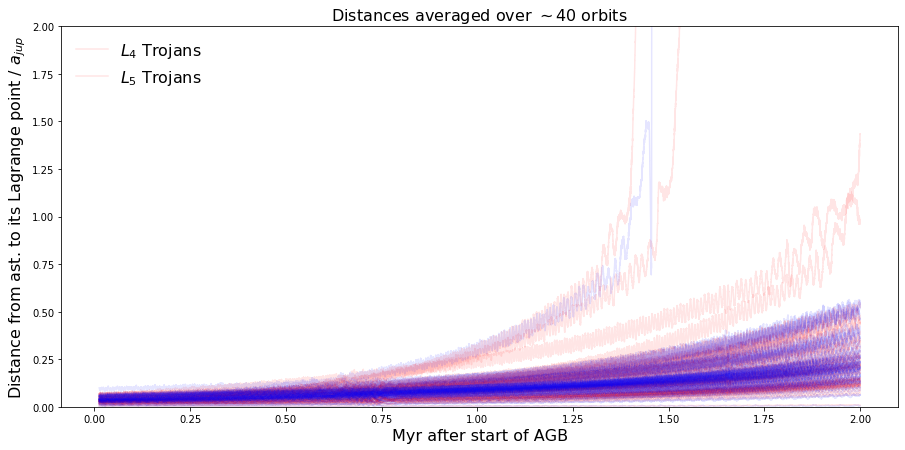

In [59]:
fig, ax = plt.subplots(figsize=(15,7))
#ax.plot(times[500:y-5000]/1e6,(r_4[500:y-5000])/a_jup[500:y-5000],'r',lw=3)
#ax.plot(times[500:y-5000]/1e6,(r_5[500:y-5000])/a_jup[500:y-5000],'b',lw=3)
#ax.plot(times[500:y-5000]/1e6,np.power(times[500:y-5000]/1e6,1/2)+r_raw4[4,501]/a_jup[501],'k',ls=":",lw=3)
ax.plot(times[500:y-5000]/1e6,(r_raw4.T[500:y-5000].T/a_jup[500:y-5000]).T, c='r', alpha=.1)
#ax.plot(times[500:y-5000]/1e6,(r_raw4.T[500:y-5000,3]/a_jup[500:y-5000]), c='r', alpha=.3)
#ax.plot(times[500:y-5000]/1e6,(r_raw4.T[500:y-5000,27]/a_jup[500:y-5000]), c='r', alpha=.3)
ax.plot(times[500:y-5000]/1e6,(r_raw5.T[500:y-5000].T/a_jup[500:y-5000]).T, c='b', alpha=.1)
#ax.legend(labels=[r"$L_4$ Trojans", r"$L_5$ Trojans"], fontsize=16, loc='upper left', frameon=False)
ax.set_xlabel("Myr after start of AGB", fontsize=16)
ax.set_ylim(0,2)
ax.set_ylabel(r"Distance from ast. to its Lagrange point / $a_\text{p}$", fontsize=16)
ax.set_title(r"Distances averaged over $\sim$40 orbits", fontsize=16)
fig.show()
fig.savefig("troj3-L-dists-w-inds-w-walk.png", dpi=300)

### Fourier Transforms of $\lambda$

In [ ]:
fft_4lambda1 = scipy.fft.rfft(np.sin(lmvals.T[end-7500:end,:num_L4]), axis=0)
fft_4lambda2 = scipy.fft.rfft(np.sin(lmvals.T[0:7500,:num_L4]), axis=0)
fft_5lambda1 = scipy.fft.rfft(np.sin(lmvals.T[end-7500:end,num_L4:]), axis=0)
fft_5lambda2 = scipy.fft.rfft(np.sin(lmvals.T[0:7500,num_L4:]), axis=0)
freq = scipy.fft.rfftfreq(times[0:7500].shape[-1])

fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
ax[0].plot(freq,np.abs(np.mean(fft_4lambda2, axis=1)), c="r", ls=":", alpha=.5)
ax[0].plot(freq,np.abs(np.mean(fft_4lambda1, axis=1)), c="r")
ax[1].plot(freq,np.abs(np.mean(fft_5lambda2, axis=1)), c="b", ls=":", alpha=.5)
ax[1].plot(freq,np.abs(np.mean(fft_5lambda1, axis=1)), c="b")
for i in range(2):
    ax[i].set_yscale("log")
    ax[i].set_xlim(0,0.17)
fig.suptitle(r"FFT of sin($\lambda$)", fontsize=14)
ax[0].legend(["start of sim", "end of sim"])
ax[0].set_title(r"Average of $L_4$ data")
ax[1].set_title(r"Average of $L_5$ data")
ax[0].set_ylabel("Power", fontsize=12)
fig.tight_layout()
fig.show()

In [ ]:
plt.plot(freq,np.abs(np.mean(fft_4lambda1, axis=1)), "r")
plt.plot(freq,np.abs(np.mean(fft_5lambda1, axis=1)), "b")
plt.yscale("log")
plt.ylabel("Power")
plt.legend([r"Average $L_4$",r"Average $L_5$"])
plt.title(r"FFT of sin($\lambda$) at end of simulation")
plt.show()

In [ ]:
fft_4lambda1 = scipy.fft.rfft(a_vals.T[end-7500:end,:num_L4], axis=0)
fft_4lambda2 = scipy.fft.rfft(a_vals.T[0:7500,:num_L4], axis=0)
fft_5lambda1 = scipy.fft.rfft(a_vals.T[end-7500:end,num_L4:], axis=0)
fft_5lambda2 = scipy.fft.rfft(a_vals.T[0:7500,num_L4:], axis=0)
freq = scipy.fft.rfftfreq(times[0:7500].shape[-1])

fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
ax[0].plot(freq,np.abs(np.mean(fft_4lambda2, axis=1)), c="r", ls=":", alpha=.5)
ax[0].plot(freq,np.abs(np.mean(fft_4lambda1, axis=1)), c="r")
ax[1].plot(freq,np.abs(np.mean(fft_5lambda2, axis=1)), c="b", ls=":", alpha=.5)
ax[1].plot(freq,np.abs(np.mean(fft_5lambda1, axis=1)), c="b")
for i in range(2):
    ax[i].set_yscale("log")
    ax[i].set_xlim(-0.01,0.2)
fig.suptitle(r"FFT of $a$", fontsize=14)
ax[0].legend(["start of sim", "end of sim"])
ax[0].set_title(r"Average of $L_4$ data")
ax[1].set_title(r"Average of $L_5$ data")
ax[0].set_ylabel("Power", fontsize=12)
fig.tight_layout()
fig.show()